# In this script, I Experiment with the Cifar-10 dataset. Moreover, I will transfer the AANN modifications to conv-deconv autoencoder architecture.
-------------------------------------------------------------------------------------------------------------------
### Technology used: Tensorflow-core 

In [1]:
# packages used for machine learning
import tensorflow as tf

# packages used for processing: 
from six.moves import cPickle as pickle # for reading the data
import matplotlib.pyplot as plt # for visualization
import numpy as np
from sklearn.preprocessing import OneHotEncoder # for encoding the labels in one hot form

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '../..'])

Data
LICENSE
Literature_survey
Models
README.md
Res
Scripts



In [4]:
''' Set the constants for the script '''

# various paths of the files
data_path = "../../Data/cifar-10" # the data path
train_meta = os.path.join(data_path, "batches.meta")
idea = "IDEA_1"
base_model_path = '../../Models'
idea_model_path = os.path.join(base_model_path, idea)

# constant values:
size = 32 # the images of size 32 x 32
channels = 3 # RGB channels
highest_pixel_value = 255.0 # 8 bits for every channel. So, max value is 255
no_of_epochs = 100 # No. of epochs to run
no_of_batches = 5 # There are 5 batches in the dataset
checkpoint_factor = 5 # save the model after every 5 steps (epochs)
num_classes = 10 # There are 10 different classes in the dataset
k_size = 5 # all kernels are 5x5
n_hidden_neurons_in_fc_layers = 512
representation_vector_length = 128 # length of the mid_level representation vector
batch_size = 128 # we look at 5000 images at a time

In [5]:
# check the contents inside the data folder
exec_command(['ls', data_path])

batches.meta
data_batch_1
data_batch_2
data_batch_3
data_batch_4
data_batch_5
readme.html
test_batch



In [6]:
# function to unPickle a file: 
def unpickle(file):
    '''
        This function takes the file path and unPickles the file acquired from it
        @Param file: the string path of the file
        @return: The dict object unPickled from the file
    '''
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

### Let's check the contents of the batches.meta file

In [7]:
meta_data = unpickle(train_meta)

# check it's contents
meta_data

{'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_cases_per_batch': 10000,
 'num_vis': 3072}

### Let's read and display some of the images from the dataset along with their labels

In [8]:
train_batch_preliminary = unpickle(os.path.join(data_path, "data_batch_3"))

# check it's contents
train_batch_preliminary.keys()

['data', 'labels', 'batch_label', 'filenames']

In [9]:
# Extract the first 3 images from the dataset
preliminary_data = train_batch_preliminary['data'].reshape((len(train_batch_preliminary['data']), 32, 32, 3), 
                                                           order='F')
preliminary_labels = train_batch_preliminary['labels']

# view some of the data:
preliminary_data[33, :10, :10, 2] #(10 x 10) data of blue channel of 33rd image

array([[178, 191, 193, 197, 202, 206, 207, 209, 214, 219],
       [140, 151, 155, 160, 166, 172, 173, 171, 176, 180],
       [ 84,  94, 119, 151, 146, 127, 125, 135, 139, 139],
       [ 16,  18,  85, 200, 207, 133,  71,  59,  72,  79],
       [  9,   3,  51, 183, 238, 219, 177,  94,  30,  16],
       [ 31,  25,  38, 148, 240, 249, 255, 235, 139,  39],
       [ 69,  65,  62, 115, 215, 250, 248, 253, 245, 201],
       [ 92,  89,  81,  89, 173, 240, 249, 253, 253, 255],
       [ 93,  90,  84,  85, 139, 217, 241, 246, 251, 252],
       [ 75,  74,  71,  87, 154, 208, 229, 239, 245, 250]], dtype=uint8)

In [10]:
# check a few values of the labels of the dataset
preliminary_labels[:10] 

[8, 5, 0, 6, 9, 2, 8, 3, 6, 2]

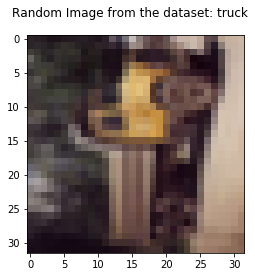

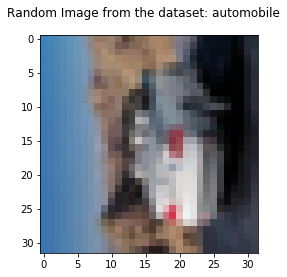

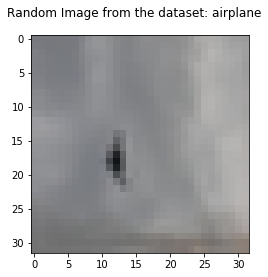

In [11]:
for _ in range(3):
    random_index = np.random.randint(preliminary_data.shape[0])
    
    plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
    plt.imshow(preliminary_data[random_index], interpolation='none')

### The images look blurred out because they are very low resolution images (32 x 32) pixels only.

## It can be seen that the images in the original dataset are skewed. So, we will have to rotate them by 90 degrees clockwise

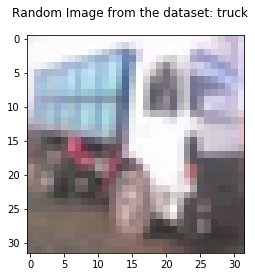

In [12]:
# let's try using the numpy.rot90 method for this:
random_index = np.random.randint(preliminary_data.shape[0])
    
plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
plt.imshow(np.rot90(preliminary_data[random_index], axes=(1, 0)), interpolation='none'); # suppress the unnecessary
# output

This works. So, now we can create a function to put all this together. This function would take the batch pickle file and create the data suitable for feeding it off to a convolutional neural network.

In [13]:
# The batch generator function:
def generateBatch(batchFile):
    '''
        The function to generate a batch of data suitable for performing the convNet operations on it
        @param batchFile -> the path of the input batchfile
        @return batch: (data, labels) -> the processed data.
    '''
    # unpickle the batch file:
    data_dict = unpickle(batchFile)
    
    # extract the data and labels from this dictionary
    unprocessed_data = data_dict['data']
    integer_labels = np.array(data_dict['labels']) # labels in integer form
    
    # reshape and rotate the data
    data = unprocessed_data.reshape((len(unprocessed_data), size, size, channels), order='F')
    processed_data = np.array(map(lambda x: np.rot90(x, axes=(1, 0)), data))
    
    # normalize the images by dividing all the pixels by 255
    processed_data = processed_data.astype(np.float32) / highest_pixel_value
    
    # encode the labels in one-hot encoded form
    # we use the sklearn.preprocessing package for doing this
    encoder = OneHotEncoder(sparse=False)
    encoded_labels = np.array(encoder.fit_transform(integer_labels.reshape(len(integer_labels), 1)))
    
    # return the processed data and the encoded_labels:
    return (processed_data, encoded_labels)

### Time to test this function

In [14]:
# load the batch no. 1 and check if it works correctly.
batch_data, batch_labels = generateBatch(os.path.join(data_path, "data_batch_1"))
print (batch_data.shape, batch_labels.shape)

# batch_data[0, :12, :12, 2]

((10000, 32, 32, 3), (10000, 10))


Random image shape: (32, 32, 3)
Random image dataTypefloat32


check if the data has been properly normalized
[[ 0.89411765  0.89411765  0.89803922]
 [ 0.90196079  0.90196079  0.90980393]
 [ 0.90196079  0.90980393  0.91764706]]


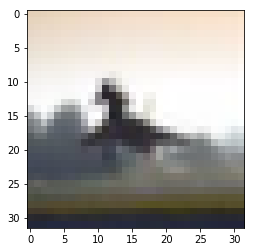

In [15]:
# extract one image from the data and display it
randomIndex = np.random.randint(batch_data.shape[0])
randomImage = batch_data[randomIndex]
print "Random image shape: " + str(randomImage.shape)

print "Random image dataType" + str(randomImage.dtype)

print "\n\ncheck if the data has been properly normalized"
print randomImage[:3, :3, 0]

# Visualize the random image from the dataset
plt.figure()
plt.imshow(randomImage, interpolation='none'); # suppress the unnecessary

Alright! So, the data extraction module is setup. Let's move on to the actual model building and training.

# Define the computation graph. This uses a conv-deconv network for the ANN concept

### define the placeholders for the computations:

In [16]:
# point to reset the graph:
tf.reset_default_graph()

In [17]:
with tf.variable_scope("Placeholders"):
    tf_input = tf.placeholder(tf.float32, shape=(None, size, size, channels), name="inputs")
    
    # add an image summary for the tf_input
    tf_input_summary = tf.summary.image("Input_images", tf_input)
    
    tf_labels = tf.placeholder(tf.float32, shape=(None, num_classes), name="labels")
    # this is to send in the representation vector tweaked by us to generate images that we want
    tf_representation_vector = tf.placeholder(tf.float32, shape=(None, num_classes), name="representation") 

In [18]:
# print all these tensors to check if they have been correctly defined
tf_input, tf_labels, tf_representation_vector
# all look good

(<tf.Tensor 'Placeholders/inputs:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'Placeholders/labels:0' shape=(?, 10) dtype=float32>,
 <tf.Tensor 'Placeholders/representation:0' shape=(?, 10) dtype=float32>)

### define the kernel and bias variables used for the computation. I am defining them separately instead of using the layers api from the latest tensorflow because I am going to use the same weights while deconvolving the representations (Use of tied weights).

In [19]:
with tf.variable_scope("Weights_and_biases"):
    # special b0 for the input images to be added when performing the backward computations
    b0 = tf.get_variable("b0", shape=(1, size, size, channels), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    # normal kernel weights and biases
    w1 = tf.get_variable("W1", shape=(k_size, k_size, channels, 4), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b1 = tf.get_variable("b1", shape=(1, 16, 16, 4), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w2 = tf.get_variable("W2", shape=(k_size, k_size, 4, 8), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b2 = tf.get_variable("b2", shape=(1, 8, 8, 8), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w3 = tf.get_variable("W3", shape=(k_size, k_size, 8, 16), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b3 = tf.get_variable("b3", shape=(1, 4, 4, 16), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w4 = tf.get_variable("W4", shape=(k_size, k_size, 16, 32), dtype=tf.float32, 
                         initializer=tf.truncated_normal_initializer())
    
    b4 = tf.get_variable("b4", shape=(1, 2, 2, 32), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    # two more weights and biases for the final fully connected layers
    
    w_fc1 = tf.get_variable("W_fc1", shape=(representation_vector_length, n_hidden_neurons_in_fc_layers), 
                            dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
    
    b_fc1 = tf.get_variable("b_fc1", shape=(1, n_hidden_neurons_in_fc_layers), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    
    w_fc2 = tf.get_variable("W_fc2", shape=(n_hidden_neurons_in_fc_layers, num_classes), dtype=tf.float32, 
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b_fc2 = tf.get_variable("b_fc2", shape=(1, num_classes), dtype=tf.float32, 
                         initializer=tf.zeros_initializer())
    

### define the forward computations

In [20]:
# define a function for the forward_computations (named as encode)
def encode(inp):
    '''
        ** Note this function uses globally defined filter and bias weights
        ** activation function used is tf.abs! (AANN idea)
        Function to encode the given input images into the final num_classes-dimensional representation vector
        @param
        inp => tensor corresponding to batch of input images
        @return => tensor of shape [batch_size x num_classes] 
    '''
    stride_pattern = [1, 2, 2, 1] # define the stride pattern to halve the image everytime
    padding_pattern = "SAME" # padding pattern for the conv layers
    
    # define the convolution layers:
    z1 = tf.nn.conv2d(inp, w1, stride_pattern, padding_pattern) + b1
    a1 = tf.abs(z1)
    
    z2 = tf.nn.conv2d(a1, w2, stride_pattern, padding_pattern) + b2
    a2 = tf.abs(z2)
    
    z3 = tf.nn.conv2d(a2, w3, stride_pattern, padding_pattern) + b3
    a3 = tf.abs(z3)
    
    z4 = tf.nn.conv2d(a3, w4, stride_pattern, padding_pattern) + b4
    a4 = tf.abs(z4)
    
    # reshape the a4 activation map:
    fc_inp = tf.reshape(a4, shape=(-1, representation_vector_length))
    
    assert fc_inp.shape[-1] == representation_vector_length, "mid_level_representation_vector isn't 128 dimensional"
    
    # define the fully connected layers:
    
    z_fc1 = tf.matmul(fc_inp, w_fc1) + b_fc1
    a_fc1 = tf.abs(z_fc1)
    
    z_fc2 = tf.matmul(a_fc1, w_fc2) + b_fc2
    a_fc2 = tf.abs(z_fc2)
    
    assert a_fc2.shape[-1] == num_classes, "final_representation_vector isn't 10 dimensional"
    
    # if everything is fine, return the final activation vectors:
    return a_fc2, tf.shape(a1), tf.shape(a2), tf.shape(a3)

In [21]:
with tf.variable_scope("Encoder"):
    y_, sha1, sha2, sha3 = encode(tf_input)

In [22]:
# check the type of y_ 
print y_
# looks good alright!

Tensor("Encoder/Abs_5:0", shape=(?, 10), dtype=float32)


### define the backward computations

In [23]:
def decode(inp, sha1, sha2, sha3):
    ''' 
        ** Note this function uses globally defined filter and bias weights
        ** activation function used is tf.abs! (AANN idea)
        Function to decode the given input representation vector into 
        the size - dimensional images that should be as close as possible
        @param
        inp => tensor corresponding to batch of representation vectors
        @return => tensor of shape [batch_size x size x size x channels]
    '''
    stride_pattern = [1, 2, 2, 1] # define the stride pattern to halve the image everytime
    padding_pattern = "SAME" # padding pattern for the conv layers
    
    # define the backward pass through the fully connected layers:
    z_b_1 = tf.matmul(inp, tf.transpose(w_fc2)) + b_fc1
    a_b_1 = tf.abs(z_b_1)
    
    z_b_2 = tf.matmul(a_b_1, tf.transpose(w_fc1)) + tf.reshape(b4, shape=(1, -1))
    a_b_2 = tf.abs(z_b_2)
    
    assert a_b_2.shape[-1] == representation_vector_length, "reverse_pass: vector not 128 dimensional"
    
    # reshape the vector into a feature map:
    dconv_in = tf.reshape(a_b_2, shape=(-1, 2, 2, 32)) # reshape into 2x2 maps
    
    # define the deconvolution operations
    z_b_dconv_1 = tf.nn.conv2d_transpose(dconv_in, w4, sha3, 
                                         stride_pattern, padding_pattern) + b3
    a_b_dconv_1 = tf.abs(z_b_dconv_1)

    
    z_b_dconv_2 = tf.nn.conv2d_transpose(a_b_dconv_1, w3, sha2,
                                        stride_pattern, padding_pattern) + b2
    a_b_dconv_2 = tf.abs(z_b_dconv_2)    
    
    
    z_b_dconv_3 = tf.nn.conv2d_transpose(a_b_dconv_2, w2, sha1,
                                        stride_pattern, padding_pattern) + b1
    a_b_dconv_3 = tf.abs(z_b_dconv_3)
    
    
    z_b_dconv_4 = tf.nn.conv2d_transpose(a_b_dconv_3, w1, tf.shape(tf_input),
                                        stride_pattern, padding_pattern) + b0
    a_b_dconv_4 = tf.abs(z_b_dconv_4)
    
    # return the final computed image:
    return a_b_dconv_4

In [24]:
with tf.variable_scope("Decoder"):
    x_ = decode(y_, sha1, sha2, sha3)
    
    # add the image summary for the x_ tensor
    x__summary = tf.summary.image("Network_generated_image", x_)

In [25]:
# check if the x_ is a good tensor
print x_
# looks good

Tensor("Decoder/Abs_5:0", shape=(?, 32, 32, 3), dtype=float32)


In [26]:
# define the decoder predictions:
with tf.variable_scope("Decoder_predictions"):
    generated_image = decode(tf_representation_vector, sha1, sha2, sha3)

In [27]:
# check sanity of the generated_image
print generated_image
# looks good! :)

Tensor("Decoder_predictions/Abs_5:0", shape=(?, 32, 32, 3), dtype=float32)


In [28]:
# define the predictions generated by the network in the forward direction:
def direction_cosines(vector):
    '''
        function to calculate the direction cosines of the given batch of input vectors
        @param
        vector => activations tensor 
        @return => the direction cosines of x
    '''
    sqr = tf.square(vector)
    div_val = tf.sqrt(tf.reduce_sum(sqr, axis=1, keep_dims=True))
    
    # return the direction cosines of the vector:
    return vector / div_val

# use this function to define the predictions:
with tf.variable_scope("Predictions"):
    predictions = direction_cosines(y_)

In [29]:
predictions

<tf.Tensor 'Predictions/div:0' shape=(?, 10) dtype=float32>

## Time to define the costs:
### Forward cost:

In [30]:
with tf.variable_scope("Forward_cost"):
    fwd_cost = tf.reduce_mean(tf.abs(predictions - tf_labels))
    
    # add scalar summary for the fwd_cost
    fwd_cost_summary = tf.summary.scalar("Forward_cost", fwd_cost)

### Backward cost:

In [31]:
with tf.variable_scope("Backward_cost"):
    bwd_cost = tf.reduce_mean(tf.abs(x_ - tf_input))
    
    # add a scalar summary for the bwd_cost
    bwd_cost_summary = tf.summary.scalar("Backward_cost", bwd_cost)

## Define the final cost and the training step:

In [32]:
with tf.variable_scope("Final_cost"):
    cost = fwd_cost + bwd_cost
    
    # add a scalar summary
    cost_summary = tf.summary.scalar("Final_cost", cost)

In [33]:
with tf.variable_scope("Trainer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_step = optimizer.minimize(cost) # minimize the final cost

## Perform the init and summary errands:

In [34]:
with tf.variable_scope("Errands"):
    init = tf.global_variables_initializer()
    all_summaries = tf.summary.merge_all()

# Create a tensorboard writer and visualize this graph before starting the training loop

In [ ]:
model_path = os.path.join(idea_model_path, "Model_cifar_3")

## Now, let's write the session code to run this computation graph and perform the training

In [ ]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is CIFAR-10, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
    
    It took me around 5hrs to execute this cell entirely.
'''

with tf.Session() as sess:
    
    tensorboard_writer = tf.summary.FileWriter(logdir=model_path, graph=sess.graph)
    saver = tf.train.Saver(max_to_keep=2)
    
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
        # load the weights from the model1
        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
    
    else:
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    g_step = 0
    for ep in range(no_of_epochs):  # epochs loop
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
        for batch_n in range(no_of_batches):  # batches loop
            # generate the batch images and labels
            batch_images, batch_labels = generateBatch(os.path.join(data_path, "data_batch_" + str(batch_n + 1)))
            
            min_batch_size = batch_size 
            
            print "current_batch: " + str(batch_n + 1)
            
            for index in range(int(np.ceil(float(len(batch_images)) / min_batch_size))):
                start = index * min_batch_size
                end = start + min_batch_size
                minX = batch_images[start: end]; minY = batch_labels[start: end]
                
                _, loss = sess.run([train_step, cost], feed_dict={tf_input: minX, tf_labels: minY})
                
                if(index % 35 ==0):
                    print('range:{} loss= {}'.format((start, end), loss))
            
                g_step += 1
                
            print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0 or ep == 0):
            
            # calculate the summaries:
            sums = sess.run(all_summaries, feed_dict={tf_input: minX, tf_labels: minY})
            
            # add the summaries to the fileWriter
            tensorboard_writer.add_summary(sums, global_step = g_step)
            
            # save the model trained so far:
            saver.save(sess, os.path.join(model_path, "model_cifar_3"), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

epoch: 1
current_batch: 1
range:(0, 128) loss= 297050.21875
range:(4480, 4608) loss= 20998.2285156
range:(8960, 9088) loss= 11556.6767578


current_batch: 2
range:(0, 128) loss= 11612.7949219
range:(4480, 4608) loss= 7605.16796875
range:(8960, 9088) loss= 6210.43847656


current_batch: 3
range:(0, 128) loss= 5558.04443359
range:(4480, 4608) loss= 4467.40771484
range:(8960, 9088) loss= 3363.94458008


current_batch: 4
range:(0, 128) loss= 3538.38012695
range:(4480, 4608) loss= 2988.40625
range:(8960, 9088) loss= 2460.4699707


current_batch: 5
range:(0, 128) loss= 2698.07788086
range:(4480, 4608) loss= 1917.81958008
range:(8960, 9088) loss= 1257.5871582


epoch: 2
current_batch: 1
range:(0, 128) loss= 1638.51293945
range:(4480, 4608) loss= 1645.82617188
range:(8960, 9088) loss= 1607.98193359


current_batch: 2
range:(0, 128) loss= 1473.32324219
range:(4480, 4608) loss= 1375.42138672
range:(8960, 9088) loss= 1049.7947998


current_batch: 3
range:(0, 128) loss= 1076.8503418
range:(4480, 4



current_batch: 2
range:(0, 128) loss= 410.23324585
range:(4480, 4608) loss= 99.5494384766
range:(8960, 9088) loss= 262.140228271


current_batch: 3
range:(0, 128) loss= 466.99609375
range:(4480, 4608) loss= 356.345062256
range:(8960, 9088) loss= 252.277603149


current_batch: 4
range:(0, 128) loss= 229.610824585
range:(4480, 4608) loss= 98.8083572388
range:(8960, 9088) loss= 61.7694702148


current_batch: 5
range:(0, 128) loss= 93.0490341187
range:(4480, 4608) loss= 34.2044029236
range:(8960, 9088) loss= 23.7714443207


epoch: 8
current_batch: 1
range:(0, 128) loss= 26.4605560303
range:(4480, 4608) loss= 24.0156955719
range:(8960, 9088) loss= 23.6341018677


current_batch: 2
range:(0, 128) loss= 23.5470466614
range:(4480, 4608) loss= 22.6018619537
range:(8960, 9088) loss= 33.3246994019


current_batch: 3
range:(0, 128) loss= 36.9929504395
range:(4480, 4608) loss= 836.348388672
range:(8960, 9088) loss= 430.937438965


current_batch: 4
range:(0, 128) loss= 390.885742188
range:(4480, 46

current_batch: 3
range:(0, 128) loss= 10.4242954254
range:(4480, 4608) loss= 15.5097932816
range:(8960, 9088) loss= 260.013122559


current_batch: 4
range:(0, 128) loss= 661.54083252
range:(4480, 4608) loss= 199.297866821
range:(8960, 9088) loss= 159.451904297


current_batch: 5
range:(0, 128) loss= 99.1088104248
range:(4480, 4608) loss= 40.835483551
range:(8960, 9088) loss= 27.5996818542


epoch: 14
current_batch: 1
range:(0, 128) loss= 37.8202476501
range:(4480, 4608) loss= 34.9654998779
range:(8960, 9088) loss= 33.5559501648


current_batch: 2
range:(0, 128) loss= 21.8922691345
range:(4480, 4608) loss= 18.6302165985
range:(8960, 9088) loss= 25.5535850525


current_batch: 3
range:(0, 128) loss= 23.1000461578
range:(4480, 4608) loss= 16.6943969727
range:(8960, 9088) loss= 20.2369365692


current_batch: 4
range:(0, 128) loss= 37.1319732666
range:(4480, 4608) loss= 21.2810878754
range:(8960, 9088) loss= 14.2280807495


current_batch: 5
range:(0, 128) loss= 21.4923057556
range:(4480, 460

range:(8960, 9088) loss= 14.9635801315


current_batch: 5
range:(0, 128) loss= 15.7625255585
range:(4480, 4608) loss= 10.6250705719
range:(8960, 9088) loss= 8.22618484497


epoch: 20
current_batch: 1
range:(0, 128) loss= 8.8668794632
range:(4480, 4608) loss= 7.51250696182
range:(8960, 9088) loss= 7.45520925522


current_batch: 2
range:(0, 128) loss= 8.29418373108
range:(4480, 4608) loss= 6.91253519058
range:(8960, 9088) loss= 6.78741693497


current_batch: 3
range:(0, 128) loss= 6.21555948257
range:(4480, 4608) loss= 5.28486585617
range:(8960, 9088) loss= 5.11699104309


current_batch: 4
range:(0, 128) loss= 5.56136798859
range:(4480, 4608) loss= 4.35606193542
range:(8960, 9088) loss= 4.40172576904


current_batch: 5
range:(0, 128) loss= 4.66072320938
range:(4480, 4608) loss= 6.61671257019
range:(8960, 9088) loss= 4.78697729111


epoch: 21
current_batch: 1
range:(0, 128) loss= 5.523624897
range:(4480, 4608) loss= 5.34062719345
range:(8960, 9088) loss= 4.1466999054


current_batch: 2
ra

current_batch: 1
range:(0, 128) loss= 2.92603826523
range:(4480, 4608) loss= 2.67879772186
range:(8960, 9088) loss= 2.93407559395


current_batch: 2
range:(0, 128) loss= 3.32041025162
range:(4480, 4608) loss= 2.66943740845
range:(8960, 9088) loss= 2.65419220924


current_batch: 3
range:(0, 128) loss= 3.05289053917
range:(4480, 4608) loss= 2.81184983253
range:(8960, 9088) loss= 2.7178235054


current_batch: 4
range:(0, 128) loss= 2.68087363243
range:(4480, 4608) loss= 2.48922348022
range:(8960, 9088) loss= 3.63354182243


current_batch: 5
range:(0, 128) loss= 8.37744235992
range:(4480, 4608) loss= 106.132766724
range:(8960, 9088) loss= 29.7537631989


epoch: 27
current_batch: 1
range:(0, 128) loss= 49.6660575867
range:(4480, 4608) loss= 18.4087276459
range:(8960, 9088) loss= 7.79830741882


current_batch: 2
range:(0, 128) loss= 13.1754026413
range:(4480, 4608) loss= 9.10216140747
range:(8960, 9088) loss= 6.01282691956


current_batch: 3
range:(0, 128) loss= 4.77459764481
range:(4480, 46

range:(8960, 9088) loss= 1.43491435051


current_batch: 3
range:(0, 128) loss= 1.47316002846
range:(4480, 4608) loss= 1.56347000599
range:(8960, 9088) loss= 1.42218637466


current_batch: 4
range:(0, 128) loss= 1.37972867489
range:(4480, 4608) loss= 1.46257972717
range:(8960, 9088) loss= 1.4612506628


current_batch: 5
range:(0, 128) loss= 1.48942923546
range:(4480, 4608) loss= 1.30035746098
range:(8960, 9088) loss= 1.28616476059


epoch: 33
current_batch: 1
range:(0, 128) loss= 1.35325682163
range:(4480, 4608) loss= 1.31376755238
range:(8960, 9088) loss= 1.27520859241


current_batch: 2
range:(0, 128) loss= 1.44685959816
range:(4480, 4608) loss= 1.28124499321
range:(8960, 9088) loss= 1.37771511078


current_batch: 3
range:(0, 128) loss= 1.46697366238
range:(4480, 4608) loss= 1.24144887924
range:(8960, 9088) loss= 1.27818346024


current_batch: 4
range:(0, 128) loss= 1.24476182461
range:(4480, 4608) loss= 1.26195120811
range:(8960, 9088) loss= 1.18881678581


current_batch: 5
range:(0,

current_batch: 4
range:(0, 128) loss= 7.37496900558
range:(4480, 4608) loss= 11.9735336304
range:(8960, 9088) loss= 3.05859041214


current_batch: 5
range:(0, 128) loss= 3.32922458649
range:(4480, 4608) loss= 1.43934190273
range:(8960, 9088) loss= 1.2346020937


epoch: 39
current_batch: 1
range:(0, 128) loss= 1.22672116756
range:(4480, 4608) loss= 1.02287709713
range:(8960, 9088) loss= 1.04655373096


current_batch: 2
range:(0, 128) loss= 1.06202876568
range:(4480, 4608) loss= 0.911342024803
range:(8960, 9088) loss= 0.929930090904


current_batch: 3
range:(0, 128) loss= 0.913509964943
range:(4480, 4608) loss= 0.930419564247
range:(8960, 9088) loss= 0.85726583004


current_batch: 4
range:(0, 128) loss= 0.834306955338
range:(4480, 4608) loss= 0.829797625542
range:(8960, 9088) loss= 0.830575704575


current_batch: 5
range:(0, 128) loss= 0.830650925636
range:(4480, 4608) loss= 0.788909435272
range:(8960, 9088) loss= 0.757615804672


epoch: 40
current_batch: 1
range:(0, 128) loss= 0.8295962

range:(4480, 4608) loss= 1.10221338272
range:(8960, 9088) loss= 7.6058716774


epoch: 45
current_batch: 1
range:(0, 128) loss= 4.36077833176
range:(4480, 4608) loss= 1.19528031349
range:(8960, 9088) loss= 0.805088162422


current_batch: 2
range:(0, 128) loss= 0.7680798769
range:(4480, 4608) loss= 0.724374949932
range:(8960, 9088) loss= 0.671897113323


current_batch: 3
range:(0, 128) loss= 0.662201285362
range:(4480, 4608) loss= 0.664011001587
range:(8960, 9088) loss= 0.643644690514


current_batch: 4
range:(0, 128) loss= 0.624852001667
range:(4480, 4608) loss= 0.623302102089
range:(8960, 9088) loss= 0.606690526009


current_batch: 5
range:(0, 128) loss= 0.624025344849
range:(4480, 4608) loss= 0.593287944794
range:(8960, 9088) loss= 0.581001639366


epoch: 46
current_batch: 1
range:(0, 128) loss= 0.597892642021
range:(4480, 4608) loss= 0.60151052475
range:(8960, 9088) loss= 0.877948045731


current_batch: 2
range:(0, 128) loss= 0.830530405045
range:(4480, 4608) loss= 0.741430461407
ran

current_batch: 1
range:(0, 128) loss= 0.542522311211
range:(4480, 4608) loss= 0.617735624313
range:(8960, 9088) loss= 1.1561923027


current_batch: 2
range:(0, 128) loss= 1.17980527878
range:(4480, 4608) loss= 0.729610621929
range:(8960, 9088) loss= 0.526245176792


current_batch: 3
range:(0, 128) loss= 0.527086615562
range:(4480, 4608) loss= 0.533553600311
range:(8960, 9088) loss= 0.5191193223


current_batch: 4
range:(0, 128) loss= 0.560496449471
range:(4480, 4608) loss= 0.858185172081
range:(8960, 9088) loss= 0.822158813477


current_batch: 5
range:(0, 128) loss= 0.826376080513
range:(4480, 4608) loss= 0.579652190208
range:(8960, 9088) loss= 0.521152377129


epoch: 52
current_batch: 1
range:(0, 128) loss= 0.576189160347
range:(4480, 4608) loss= 0.514416754246
range:(8960, 9088) loss= 0.56492638588


current_batch: 2
range:(0, 128) loss= 0.67197650671
range:(4480, 4608) loss= 1.04045081139
range:(8960, 9088) loss= 0.592113435268


current_batch: 3
range:(0, 128) loss= 0.598350465298


current_batch: 2
range:(0, 128) loss= 0.492028415203
range:(4480, 4608) loss= 0.497067421675
range:(8960, 9088) loss= 0.507441759109


current_batch: 3
range:(0, 128) loss= 0.488400906324
range:(4480, 4608) loss= 0.49641802907
range:(8960, 9088) loss= 0.468145787716


current_batch: 4
range:(0, 128) loss= 0.487434327602
range:(4480, 4608) loss= 0.465622663498
range:(8960, 9088) loss= 0.472542673349


current_batch: 5
range:(0, 128) loss= 0.483825713396
range:(4480, 4608) loss= 0.47651797533
range:(8960, 9088) loss= 0.500248789787


epoch: 58
current_batch: 1
range:(0, 128) loss= 0.490538060665
range:(4480, 4608) loss= 0.463297247887
range:(8960, 9088) loss= 0.472294062376


current_batch: 2
range:(0, 128) loss= 0.517045199871
range:(4480, 4608) loss= 0.480107247829
range:(8960, 9088) loss= 0.467770397663


current_batch: 3
range:(0, 128) loss= 0.474353134632
range:(4480, 4608) loss= 0.472161948681
range:(8960, 9088) loss= 0.489251255989


current_batch: 4
range:(0, 128) loss= 0.4698966

current_batch: 3
range:(0, 128) loss= 0.404535651207
range:(4480, 4608) loss= 0.420144319534
range:(8960, 9088) loss= 0.4089217484


current_batch: 4
range:(0, 128) loss= 0.407040834427
range:(4480, 4608) loss= 0.408520340919
range:(8960, 9088) loss= 0.405183970928


current_batch: 5
range:(0, 128) loss= 0.416690707207
range:(4480, 4608) loss= 0.416184365749
range:(8960, 9088) loss= 0.403614193201


epoch: 64
current_batch: 1
range:(0, 128) loss= 0.396458655596
range:(4480, 4608) loss= 0.405972957611
range:(8960, 9088) loss= 0.408661842346


current_batch: 2
range:(0, 128) loss= 0.413818359375
range:(4480, 4608) loss= 0.412737578154
range:(8960, 9088) loss= 0.409462511539


current_batch: 3
range:(0, 128) loss= 0.402886301279
range:(4480, 4608) loss= 0.414634108543
range:(8960, 9088) loss= 0.404457092285


current_batch: 4
range:(0, 128) loss= 0.402274042368
range:(4480, 4608) loss= 0.399091601372
range:(8960, 9088) loss= 0.398717343807


current_batch: 5
range:(0, 128) loss= 0.4044253

current_batch: 4
range:(0, 128) loss= 0.392055988312
range:(4480, 4608) loss= 0.391485124826
range:(8960, 9088) loss= 0.387776374817


current_batch: 5
range:(0, 128) loss= 0.392530322075
range:(4480, 4608) loss= 0.392115950584
range:(8960, 9088) loss= 0.386073470116


epoch: 70
current_batch: 1
range:(0, 128) loss= 0.38003924489
range:(4480, 4608) loss= 0.397947132587
range:(8960, 9088) loss= 0.39412355423


current_batch: 2
range:(0, 128) loss= 0.399798035622
range:(4480, 4608) loss= 0.399213731289
range:(8960, 9088) loss= 0.396336585283


current_batch: 3
range:(0, 128) loss= 0.387536764145
range:(4480, 4608) loss= 0.402597427368
range:(8960, 9088) loss= 0.393745064735


current_batch: 4
range:(0, 128) loss= 0.392425268888
range:(4480, 4608) loss= 0.390292644501
range:(8960, 9088) loss= 0.387356370687


current_batch: 5
range:(0, 128) loss= 0.391326963902
range:(4480, 4608) loss= 0.390517413616
range:(8960, 9088) loss= 0.385247498751


epoch: 71
current_batch: 1
range:(0, 128) loss=

current_batch: 5
range:(0, 128) loss= 0.377181112766
range:(4480, 4608) loss= 0.367169231176
range:(8960, 9088) loss= 0.364394366741


epoch: 76
current_batch: 1
range:(0, 128) loss= 0.36064183712
range:(4480, 4608) loss= 0.369359970093
range:(8960, 9088) loss= 0.368951737881


current_batch: 2
range:(0, 128) loss= 0.378700107336
range:(4480, 4608) loss= 0.374031960964
range:(8960, 9088) loss= 0.371026068926


current_batch: 3
range:(0, 128) loss= 0.362809240818
range:(4480, 4608) loss= 0.379308283329
range:(8960, 9088) loss= 0.370144546032


current_batch: 4
range:(0, 128) loss= 0.365950882435
range:(4480, 4608) loss= 0.36640393734
range:(8960, 9088) loss= 0.360941827297


current_batch: 5
range:(0, 128) loss= 0.37279266119
range:(4480, 4608) loss= 0.361913740635
range:(8960, 9088) loss= 0.361365020275


epoch: 77
current_batch: 1
range:(0, 128) loss= 0.354074180126
range:(4480, 4608) loss= 0.364283174276
range:(8960, 9088) loss= 0.367216765881


current_batch: 2
range:(0, 128) loss= 

current_batch: 1
range:(0, 128) loss= 0.350113272667
range:(4480, 4608) loss= 0.359335482121
range:(8960, 9088) loss= 0.362311720848


current_batch: 2
range:(0, 128) loss= 0.369343936443
range:(4480, 4608) loss= 0.366439938545
range:(8960, 9088) loss= 0.364026844501


current_batch: 3
range:(0, 128) loss= 0.355989605188
range:(4480, 4608) loss= 0.373546183109
range:(8960, 9088) loss= 0.363753437996


current_batch: 4
range:(0, 128) loss= 0.360596567392
range:(4480, 4608) loss= 0.361469388008
range:(8960, 9088) loss= 0.355493336916


current_batch: 5
range:(0, 128) loss= 0.368785560131
range:(4480, 4608) loss= 0.356828331947
range:(8960, 9088) loss= 0.356269478798


epoch: 83
current_batch: 1
range:(0, 128) loss= 0.350901663303
range:(4480, 4608) loss= 0.35867279768
range:(8960, 9088) loss= 0.361232161522


current_batch: 2
range:(0, 128) loss= 0.368214666843
range:(4480, 4608) loss= 0.366028428078
range:(8960, 9088) loss= 0.363717794418


current_batch: 3
range:(0, 128) loss= 0.356677

current_batch: 2
range:(0, 128) loss= 0.364731013775
range:(4480, 4608) loss= 0.364786297083
range:(8960, 9088) loss= 0.36257481575


current_batch: 3
range:(0, 128) loss= 0.355176448822
range:(4480, 4608) loss= 0.371299624443
range:(8960, 9088) loss= 0.362136691809


current_batch: 4
range:(0, 128) loss= 0.358260929585
range:(4480, 4608) loss= 0.359352111816
range:(8960, 9088) loss= 0.35407859087


current_batch: 5
range:(0, 128) loss= 0.36629062891
range:(4480, 4608) loss= 0.354651808739
range:(8960, 9088) loss= 0.355090022087


epoch: 89
current_batch: 1
range:(0, 128) loss= 0.349740326405
range:(4480, 4608) loss= 0.356665313244
range:(8960, 9088) loss= 0.360273778439


current_batch: 2
range:(0, 128) loss= 0.365050643682
range:(4480, 4608) loss= 0.364505589008
range:(8960, 9088) loss= 0.362019389868


current_batch: 3
range:(0, 128) loss= 0.355832666159
range:(4480, 4608) loss= 0.371113598347
range:(8960, 9088) loss= 0.362154960632


current_batch: 4
range:(0, 128) loss= 0.35828047

current_batch: 3
range:(0, 128) loss= 0.354759007692
range:(4480, 4608) loss= 0.370839595795
range:(8960, 9088) loss= 0.361482769251


current_batch: 4
range:(0, 128) loss= 0.35776796937
range:(4480, 4608) loss= 0.358216762543
range:(8960, 9088) loss= 0.353283941746


current_batch: 5
range:(0, 128) loss= 0.364710628986
range:(4480, 4608) loss= 0.352907121181
range:(8960, 9088) loss= 0.354478538036


epoch: 95
current_batch: 1
range:(0, 128) loss= 0.346193253994
range:(4480, 4608) loss= 0.354989737272
range:(8960, 9088) loss= 0.358688920736


current_batch: 2
range:(0, 128) loss= 0.365386128426
range:(4480, 4608) loss= 0.362732201815
range:(8960, 9088) loss= 0.360033035278


current_batch: 3
range:(0, 128) loss= 0.354348659515
range:(4480, 4608) loss= 0.370700478554
range:(8960, 9088) loss= 0.361165970564


current_batch: 4
range:(0, 128) loss= 0.357994019985
range:(4480, 4608) loss= 0.357935547829
range:(8960, 9088) loss= 0.353588432074


current_batch: 5
range:(0, 128) loss= 0.365372

In [ ]:
g_step